# Data Collection

<div style="direction:rtl"> 
    <font size="4", color="red">
        به منظور جمع آوری دادگان مورد نیاز، یک crawler پیاده‌سازی شد(به کمک scrappy) که به کمک آن دادگان پست‌های مربوط به فروش املاک در سایت دیوار برای چند شهر متفاوت crawl شده اند. در ازای هر شهر تمامی آگهی های فروش املاک آن تا صفحه‌ی ۱۹ ام crawl شده‌اند. هر صحفه دیوار شامل ۲۴ آگهی می‌باشد.
        اسکریپت‌های مربوط به crawler نوشته شده به همراه داده های جمع آوری شده در کنار این نوت‌بوک قابل دسترس هستند.
    </font> 
</div>

# Install packages

In [234]:
import sys
!{sys.executable} -m pip install -r ./requirements.txt

  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
  Using cached Scrapy-2.7.1-py2.py3-none-any.whl (271 kB)
  Using cached itemadapter-0.7.0-py3-none-any.whl (10 kB)
  Using cached sklearn-0.0-py2.py3-none-any.whl
  Using cached charset_normalizer-2.1.1-py3-none-any.whl (39 kB)
  Using cached itemloaders-1.0.6-py3-none-any.whl (11 kB)
  Using cached w3lib-2.0.1-py3-none-any.whl (20 kB)
  Using cached pyOpenSSL-22.1.0-py3-none-any.whl (57 kB)
  Using cached Protego-0.2.1-py2.py3-none-any.whl (8.2 kB)
     |████████████████████████████████| 3.1 MB 828 kB/s eta 0:00:01
  Using cached tldextract-3.4.0-py3-none-any.whl (93 kB)
  Using cached service_identity-21.1.0-py2.py3-none-any.whl (12 kB)
  Using cached PyDispatcher-2.0.6.tar.gz (38 kB)
  Using cached queuelib-1.6.2-py2.py3-none-any.whl (13 kB)
     |████████████████████████████████| 2.8 MB 31.3 MB/s eta 0:00:01
  Using cached hyperlink-21.0.0-py2.py3-none-any.whl (74 kB)
  Using cached incremental-22.10.0-py2.py3-none-any.whl (1

In [235]:
import sys
!{sys.executable} -m pip install git+https://github.com/language-ml/parsi.io.git

  Cloning https://github.com/language-ml/parsi.io.git to /private/var/folders/4w/bx7cryln5tl_kklxmx7l_3xc0000gn/T/pip-req-build-px1v21u5
  Running command git clone -q https://github.com/language-ml/parsi.io.git /private/var/folders/4w/bx7cryln5tl_kklxmx7l_3xc0000gn/T/pip-req-build-px1v21u5


# Import packages

In [21]:
import random
import numpy as np
import pandas as pd
import re
import tqdm
import itertools
import nltk
from nltk import FreqDist

import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

import hazm
from hazm import Normalizer, Stemmer, Lemmatizer
from hazm import WordTokenizer, SentenceTokenizer, word_tokenize
import emoji

from parsi_io.modules.address_extractions import AddressExtraction

# Data loading

<div style="direction:rtl"> 
    <font size="4", color="red">
        در این قسمت داده‌های crawl شده خوانده می‌شوند و کنار یکدیگر قرار می‌گیرند. همچنین یک ستون جدید به داده‌ها اضافه می‌شوند که نشان می‌دهد هر سطر مربوط به چه شهری است. از این ویژگی در ادامه به منظور مقایسه‌ی مواردی بین شهرها استفاده می‌شود.
    </font> 
</div>

In [411]:
def get_concatenated_data():
    tehran_posts = pd.read_csv('data/tehran-apartment-sell-posts.csv')
    mashhad_posts = pd.read_csv('data/mashhad-apartment-sell-posts.csv')
    isfahan_posts = pd.read_csv('data/isfahan-apartment-sell-posts.csv')
    sari_posts = pd.read_csv('data/sari-apartment-sell-posts.csv')
    tabriz_posts = pd.read_csv('data/tabriz-apartment-sell-posts.csv')
    shiraz_posts = pd.read_csv('data/shiraz-apartment-sell-posts.csv')
    mahmoodabad_posts = pd.read_csv('data/mahmoodabad-apartment-sell-posts.csv')

    tehran_posts['city'] = 'tehran'
    mashhad_posts['city'] = 'mashhad'
    isfahan_posts['city'] = 'isfahan'
    sari_posts['city'] = 'sari'
    tabriz_posts['city'] = 'tabriz'
    shiraz_posts['city'] = 'shiraz'
    mahmoodabad_posts['city'] = 'mahmoodabad'

    posts = pd.concat([tehran_posts, mashhad_posts, isfahan_posts, sari_posts, tabriz_posts, shiraz_posts, mahmoodabad_posts], ignore_index=True)

    return posts

In [412]:
posts = get_concatenated_data()

# Clean data

### Big picture

In [413]:
posts.head()

,Area,Construction,Room,Warehouse,Parking,Elevator,Address,Price,Description,city
0,63,1375,1,False,False,True,دقایقی پیش در تهران، شمشیری، خیابان شمشیری (ب....,۱٬۶۰۰٬۰۰۰٬۰۰۰ تومان,"<p class=""kt-description-row__text kt-descript...",tehran
1,180,1393,3,True,True,True,دقایقی پیش در تهران، شیان | فروش آپارتمان,۱۴٬۰۰۰٬۰۰۰٬۰۰۰ تومان,"<p class=""kt-description-row__text kt-descript...",tehran
2,38,1380,1,False,False,True,دقایقی پیش در تهران، پلیس | فروش آپارتمان,۱٬۳۸۰٬۰۰۰٬۰۰۰ تومان,"<p class=""kt-description-row__text kt-descript...",tehran
3,88,1384,2,True,True,True,دقایقی پیش در تهران، تهران‌نو | فروش آپارتمان,۳٬۵۰۰٬۰۰۰٬۰۰۰ تومان,"<p class=""kt-description-row__text kt-descript...",tehran
4,40,1393,1,True,True,True,دقایقی پیش در تهران، بریانک | فروش آپارتمان,۱٬۴۲۰٬۰۰۰٬۰۰۰ تومان,"<p class=""kt-description-row__text kt-descript...",tehran


In [414]:
posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3167 entries, 0 to 3166
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Area          3167 non-null   int64 
 1   Construction  3167 non-null   int64 
 2   Room          3167 non-null   int64 
 3   Warehouse     3167 non-null   bool  
 4   Parking       3167 non-null   bool  
 5   Elevator      3167 non-null   bool  
 6   Address       3167 non-null   object
 7   Price         3167 non-null   object
 8   Description   3167 non-null   object
 9   city          3167 non-null   object
dtypes: bool(3), int64(3), object(4)
memory usage: 182.6+ KB


In [415]:
posts.describe()

,Area,Construction,Room
count,3167.000000,3167.000000,3167.000000
mean,125.015156,1395.660562,2.248816
std,122.244390,6.074243,0.654913
min,1.000000,1371.000000,1.000000
25%,87.000000,1392.000000,2.000000
50%,112.000000,1398.000000,2.000000
75%,144.000000,1401.000000,3.000000
max,6000.000000,1401.000000,4.000000


### Examples of collected data

In [427]:
for desc in random.sample(list(posts.Description.values), 5):
    print(desc)
    print('\n' + '#'*100 + '\n')

<p class="kt-description-row__text kt-description-row__text--primary">««فایلینگ اختصاصی»»

☑️بهترین گزینه برای خرید
☑️دسترسی عالی مراکز خرید و رفاهی
☑️دسترسی چند قدمی به مترو
☑️محله ای دنج و آرام
☑️کم واحد ( کلا 10واحد)
☑️طبقه5
☑️نور عالی «دوکله»
☑️سالن بزرگ و خوش نقشه
☑️کناف و نورپردازی
☑️آشپزخانه شیک و پر کابینت
☑️2خواب بزرگ در فضای خصوصی واحد
☑️کمد دیواری جادار و عمیق
☑️پارکینگ مسقف / انباری / آسانسور</p>

####################################################################################################

<p class="kt-description-row__text kt-description-row__text--primary">❌زیر قیمت منطقه فرصتی ایده آل❌ ‎ 

‼️فوری فوری فوری ‼️ ‎

تک واحدی طبقه چهارم

✅محله ای با اصالت و لوکیشن قوی آفتاب همیشه مهمان خانه شماست✅ ‎ 

❌ سالن پرده خور دو کله نور ❌ ‎ 

✅عماراتی شیک و منحصر به فرد ‎ 
✅ مختص سخت پسندان ‎ 
کوچه ای دنج و دسترسی سریع به اتوبان ‎ 

✔️زیر قیمت. مناسب سرمایه گذاری❗ 
فوق العاده عالی بی نظیر ترین فایل منطقه✅ 

بهترین واحد های منطقه ۵ را از ما بخواهید ✔️ ‎برای کسب اطلاعات و معرفی 

### Clean Address feature

<div style="direction:rtl"> 
    <font size="4", color="red">
        همانطور که از ابتدای متن آدرس‌ها مشخص است نوع آگهی در آن آمده است. به طور مثال در نمونه‌ی زیر فروش آپارتمان زیاد است و ربطی به آدرس این ملک ندارد که می‌بایست حذف شود.
        همچنین زمان آگهی نیز اضافه است که در تمامی مقادیر این ستون آمده است. به طور مثال در نمونه‌ی زیر دقایقی پیش در تهران ربطی به آدرس آن ندارد که می‌بایست حذف شود.
    </font> 
</div>

In [428]:
posts.Address[0]

'دقایقی پیش در تهران، شمشیری، خیابان شمشیری (ب. ایت الله سعیدی) | فروش آپارتمان'

In [429]:
class ExtractAddressTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X.Address = X.Address.apply(
            lambda adress: '،'.join(adress.split('|')[0].split('،')[1:])
        )
        return X

In [430]:
t = ExtractAddressTransformer()

In [431]:
posts = t.fit_transform(posts)

In [432]:
posts.Address[0]

' شمشیری، خیابان شمشیری (ب. ایت الله سعیدی) '

### Clean Description feature

<div style="direction:rtl"> 
    <font size="4">
        همانطور که از ابتدای متن توضیحات آگهی‌ها مشخص است، یک تگ html ابتدای هر یک توضیحات آگهی‌ها آمده است که نشان دهنده‌ی تگ کلاس html توضیحات آگهی است و ارتباطی به محتوی آن ندارد که می‌بایست حذف شود.
    </font> 
</div>

In [433]:
posts.Description[1]

'<p class="kt-description-row__text kt-description-row__text--primary">برج باغ با موقعیت دنج و آرام/ چشم انداز پارک جنگلی و قله دماوند/ 3خواب، یک مستر/ لابی بزرگ/ سرایدار مقیم/ بالکن مفید/ ژنراتور برق/ چیلر مرکزی/ اطفای حریق/دوربین مداربسته/ بدون دیوار مشترک/ نورگیر از شمال، شرق و غرب واحد/ حیاط بزرگ و مشجر با آبنما، آلاچیق و چاه آب/ روف گاردن/ پیاده تا پارک جنگلی ده دقیقه.\nلطفا املاک تماس نگیرند.</p>'

In [434]:
class RemoveTagTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.cleanre = re.compile('<.*?>') 
        return self
    def transform(self, X):
        X.Description = X.Description.apply(
            lambda desc: re.sub(self.cleanre, '', desc)
        )
        return X

In [435]:
t = RemoveTagTransformer()
posts = t.fit_transform(posts)

In [436]:
posts.Description[1]

'برج باغ با موقعیت دنج و آرام/ چشم انداز پارک جنگلی و قله دماوند/ 3خواب، یک مستر/ لابی بزرگ/ سرایدار مقیم/ بالکن مفید/ ژنراتور برق/ چیلر مرکزی/ اطفای حریق/دوربین مداربسته/ بدون دیوار مشترک/ نورگیر از شمال، شرق و غرب واحد/ حیاط بزرگ و مشجر با آبنما، آلاچیق و چاه آب/ روف گاردن/ پیاده تا پارک جنگلی ده دقیقه.\nلطفا املاک تماس نگیرند.'

# Preprocess

### Remove imojies

<div style="direction:rtl"> 
    <font size="4", color="red">
        از آنجا که در بسیاری از توضیحات آگهی‌های دیوار از ایموجی ها به دلایل متفاوت استفاده می‌شود، حجم قابل توجهی از متن آنها را ایموجی‌ها به خود تخصیص می‌دهند که عمدتا به منظور جداسازی محتوای توضیحات آگهی آورده می‌شوند و بار معنایی ندارند. به همین منظور آنها را یک transformer به منظور پاک کردن آنها از متن توضیحات می‌نویسیم.
    </font> 
</div>

In [437]:
posts.Description[0]

'✴️دونبش\n✴️ تک واحدی \n✴️ از سه جهت غرق در نور\n✴️ دسترسی و لوکیشن عالی\n✴️ بازسازی، نقاشی و کاغذدیواری شده \n✴️ سرویس و حمام صفر تا صد بازسازی شده\n✴️ شیرآلات، روشویی، توالت ایرانی و فرنگی نو\n✴️ انباری غیر سندی\n✴️ بازدید هر ساعت از روز بدون معطلی\n\nمشاور شما سعید اختری زاده'

In [438]:
class RemoveEmojiesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X[self.column_name] = X[self.column_name].apply(
            lambda text: emoji.get_emoji_regexp().sub(r'', text)
        )
        return X

In [439]:
t = RemoveEmojiesTransformer(column_name='Description')
posts = t.fit_transform(posts)

In [440]:
posts.Description[0]

'دونبش\n تک واحدی \n از سه جهت غرق در نور\n دسترسی و لوکیشن عالی\n بازسازی، نقاشی و کاغذدیواری شده \n سرویس و حمام صفر تا صد بازسازی شده\n شیرآلات، روشویی، توالت ایرانی و فرنگی نو\n انباری غیر سندی\n بازدید هر ساعت از روز بدون معطلی\n\nمشاور شما سعید اختری زاده'

### Description Transformer

<div style="direction:rtl"> 
    <font size="4", color="red">
        در ادامه یک transformer به منظور مابقی پیش پردازش‌های متنی مورد نظر روی توضیحات پیاده‌سازی شده است که در آن عملیات‌هایی از قبیل تبدیل ي به ی و همچنین حذف اعراب عربی، حذف عبارات انگلیسی از متن و lemmatize کردن متن انجام می‌گیرد. 
    </font> 
</div>

In [441]:
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

def isEnglish(s):
    return s.lower().islower()

In [442]:
class DescriptionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name
    
    def fit(self, X, y=None):
        stop_words_file = open("stopwords.txt", "r")
        content = stop_words_file.read()
        self.stopwords = content.split("\n")
        
        self.normalizer = Normalizer()
        self.lemmatizer = Lemmatizer()
        
        self.tokenizer = WordTokenizer(join_verb_parts=False, replace_links=True, replace_numbers=True)
        return self
    
    def transform(self, X):
        cleaned = []
        
        for text in X[self.column_name]:
            # tokenize - replace link-number
            words = self.tokenizer.tokenize(' '.join(self.tokenizer.tokenize(text)))
            # replace ي with ی and remove arabic symbols
            words = [self.normalizer.character_refinement(word) for word in words]

            words = [word for word in words if not isEnglish(word)]
#             words = [word for word in words if not hasNumbers(word)]

            text = ' '.join([self.lemmatizer.lemmatize(word) for word in words])
            cleaned.append(text)
        
        X[self.column_name] = cleaned
        return X

In [443]:
desc_transformer = DescriptionTransformer(column_name='Description')

In [444]:
posts = desc_transformer.fit_transform(posts)

In [445]:
posts.Description[0]

'دونبش تک واحد از سه جهت غرق در نور دسترس و لوکیشن عالی بازسازی ، نقاش و کاغذدیواری شده سرویس و حمام صفر تا صد بازسازی شده شیرآلات ، روشویی ، توالت ایران و فرنگ نو انباری غیر سند بازدید هر ساعت از روز بدون معطل مشاور شما سعید اختر زاده'

# Remove stopwords transformer

<div style="direction:rtl"> 
    <font size="4", color="red">
        در این قسمت یک transformer به منظور حذف stopword های فارسی از متن پیاده سازی شده است. فایل stopwords های فارسی استفاده شده از ریپازیتوری زیر گرفته شده است.
        https://github.com/kharazi/persian-stopwords
    </font> 
</div>

In [446]:
class RemoveStopwordsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name
    
    def fit(self, X, y=None):
        stop_words_file = open("stopwords.txt", "r")
        content = stop_words_file.read()
        self.stopwords = content.split("\n")
        
        self.tokenizer = WordTokenizer(join_verb_parts=False, replace_links=True, replace_numbers=True)
        return self
    
    def transform(self, X):
        cleaned = []
        
        for text in X[self.column_name]:
            words = self.tokenizer.tokenize(' '.join(self.tokenizer.tokenize(text)))
            words = [word for word in words if word not in self.stopwords]

            text = ' '.join(words)
            cleaned.append(text)
        
        X[self.column_name] = cleaned
        return X

In [447]:
sw_transformer = RemoveStopwordsTransformer(column_name='Description')

In [448]:
posts = sw_transformer.fit_transform(posts)

In [449]:
posts.Description[0]

'دونبش تک واحد سه غرق نور دسترس لوکیشن عالی بازسازی نقاش کاغذدیواری سرویس حمام صفر بازسازی شیرآلات روشویی توالت ایران فرنگ نو انباری سند بازدید ساعت معطل مشاور سعید اختر زاده'

In [470]:
for desc in random.sample(list(posts.Description.values), 5):
    print(desc)
    print('\n' + '#'*100 + '\n')

فروش فوری قیمت پول لازم سازنده بنام متریال درجه پرت املاک دلال کار نمیشود

####################################################################################################

طبقه واحد طبقه ۴نما ساختمان دونبش فول امکانات تجهیزات نصب واحد خال تحویل تراس اتاق روبه نما کوچه فروش نقد موقعیت مکان زینبیه خیابون متری پهن مسکن بزرگمهر مهندس میثم ملایی خرید فروش رهن اجاره آپارتمان نوساز صفر کارکرده قدیم خرید فروش وام لوکس پنت هاوس اداری تجار آسانسوردار پارکینگ زمین شهرخانه ملک کلنگ ساخت مسکونی تجار مشارکت بافت باغ زراع شالیزار پلاک کوچک تفکیک هکتار ییلاق ساحل جاده دریا پلاژ ویلا استخردارمغازه سوله کارخانه انبارزیرزمین صنعتی سردخانه مرغداری استخرماهی گلخانه مجوز وام سند دستدارمی امکانات برق آب دسترس دارا معاوضه تهاتربا مصالح سرمایه گذاشت#گذار انبوه ساری شمال مازندران تبلیغ ملک سپارد#سپار مشاور زجاج

####################################################################################################

آپارتمان نظر دارا امکانات آسانسور پارکینگ انباری سند تک‌برگ قیمت ذکر صحبت تخفیف املاک عارف خداد

# Notebook body

<div style="direction:rtl"> 
    <font size="4", color="red">
        در این قسمت به بررسی مواردی در متن توضیحات آگهی‌ها می‌پردازیم و آنها را در چند شهر مورد نظر که دیتای آنها crawl شده است، با یکدیگر مقایسه می‌کنیم. 
    </font> 
</div>

<div style="direction:rtl"> 
    <font size="4", color="red">
        در ابندا داده‌ی اولیه را به کمک نورمالایزر کتابخانه هزم نرمالایز می‌کنیم. 
    </font> 
</div>

In [471]:
posts = get_concatenated_data()

In [472]:
normalizer = Normalizer()
posts.Description = [normalizer.normalize(desc) for desc in tqdm.tqdm(posts.Description)]

100%|██████████| 3167/3167 [00:00<00:00, 6492.05it/s]


In [473]:
posts.head()

,Area,Construction,Room,Warehouse,Parking,Elevator,Address,Price,Description,city
0,63,1375,1,False,False,True,دقایقی پیش در تهران، شمشیری، خیابان شمشیری (ب....,۱٬۶۰۰٬۰۰۰٬۰۰۰ تومان,<p class= «kt-description-row__text kt-descrip...,tehran
1,180,1393,3,True,True,True,دقایقی پیش در تهران، شیان | فروش آپارتمان,۱۴٬۰۰۰٬۰۰۰٬۰۰۰ تومان,<p class= «kt-description-row__text kt-descrip...,tehran
2,38,1380,1,False,False,True,دقایقی پیش در تهران، پلیس | فروش آپارتمان,۱٬۳۸۰٬۰۰۰٬۰۰۰ تومان,<p class= «kt-description-row__text kt-descrip...,tehran
3,88,1384,2,True,True,True,دقایقی پیش در تهران، تهران‌نو | فروش آپارتمان,۳٬۵۰۰٬۰۰۰٬۰۰۰ تومان,<p class= «kt-description-row__text kt-descrip...,tehran
4,40,1393,1,True,True,True,دقایقی پیش در تهران، بریانک | فروش آپارتمان,۱٬۴۲۰٬۰۰۰٬۰۰۰ تومان,<p class= «kt-description-row__text kt-descrip...,tehran


### Number of words per description

<div style="direction:rtl"> 
    <font size="4", color="red">
        در این قسمت میانگین تعداد کلمات در توضیحات هر آگهی را بدست آورده و این مقدار را در شهرهای مورد نظر مقایسه می‌کنیم. برای این منظور از توکنایزر هزم استفاده می‌کنیم. 
    </font> 
</div>

In [474]:
tokenizer = WordTokenizer(join_verb_parts=False, replace_links=True)

In [475]:
# calculate number of words per description
posts['n_words'] = posts.Description.apply(
    lambda desc: len(tokenizer.tokenize(desc))
)

In [476]:
n_words_per_city = posts.groupby(['city'])['n_words'].mean()

<div style="direction:rtl"> 
    <font size="4", color="red">
         همانطور که در نمودار زیر پیداست آگهی‌های املاک شهر تبریز در این بازه زمانی به طور میانگین بیشترین تعداد کلمه‌ی استفاده شده را دارند. از طرف دیگر به ترتیب شهرهای ساری و شیراز کمترین تعداد کلمه‌ی استفاده شده در توضیحات آگهی‌های فروش املاک را دارند.
    </font> 
</div>

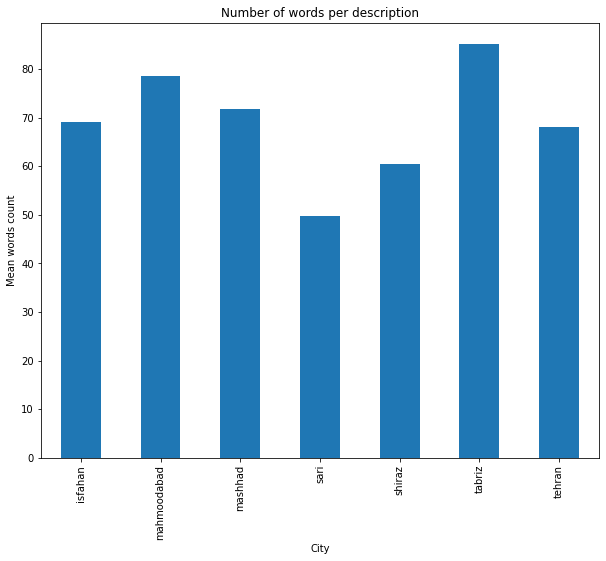

In [477]:
_ = n_words_per_city.plot(kind='bar', 
                      title='Number of words per description', 
                      ylabel='Mean words count',
                      xlabel='City', 
                      figsize=(10, 8))

### Number of sentences  per description

<div style="direction:rtl"> 
    <font size="4", color="red">
        در این قسمت میانگین تعداد جملات در توضیحات هر آگهی را بدست آورده و این مقدار را در شهرهای مورد نظر مقایسه می‌کنیم. برای این منظور از توکنایزر هزم استفاده می‌کنیم. 
    </font> 
</div>

In [478]:
sentence_tokenizer = SentenceTokenizer()

In [479]:
# calculate number of words per description
posts['n_sentences'] = posts.Description.apply(
    lambda desc: len(sentence_tokenizer.tokenize(desc))
)

In [480]:
n_sentences_per_city = posts.groupby(['city'])['n_sentences'].mean()

In [481]:
posts.Description[0]

'<p class= «kt-description-row__text kt-description-row__text--primary» >✴️دونبش\n✴️ تک واحدی \n✴️ از سه جهت غرق در نور\n✴️ دسترسی و لوکیشن عالی\n✴️ بازسازی، نقاشی و کاغذدیواری شده \n✴️ سرویس و حمام صفر تا صد بازسازی شده\n✴️ شیرآلات، روشویی، توالت ایرانی و فرنگی نو\n✴️ انباری غیر سندی\n✴️ بازدید هر ساعت از روز بدون معطلی\n\nمشاور شما سعید اختری زاده</p>'

<div style="direction:rtl"> 
    <font size="4", color="red">
         همانطور که در نمودار زیر پیداست آگهی‌های املاک شهر تبریز در این بازه زمانی به طور میانگین بیشترین تعداد جمله‌ی استفاده شده را دارند. از طرف دیگر به ترتیب شهرهای ساری، محمودآباد و شیراز کمترین تعداد جمله‌ی استفاده شده در توضیحات آگهی‌های فروش املاک را دارند.
    </font> 
</div>

<div style="direction:rtl"> 
    <font size="4", color="red">
         اما نکته‌ای که قابل تامل است این است که در میانگین تعداد کلمات، شهر تهران سومین کمترین تعداد کلمه را به ازای هر آگهی داشت در صورت که از نظر تعداد جمله دومین بیشترین تعداد جمله را در خود دارد که می‌تواند نشان از این داشته باشد که افرادی که در تهران آگهی می‌گذارند، عموما از جملاتی با تعداد کلمات کمتر استفاده می‌کنند. عکس همین موضوع در شهر محمودآباد به چشم می‌خورد. برای بررسی این موضوع صحت این متریک را در قسمت بعد محاسبه و مقایسه می‌کنیم.
    </font> 
</div>

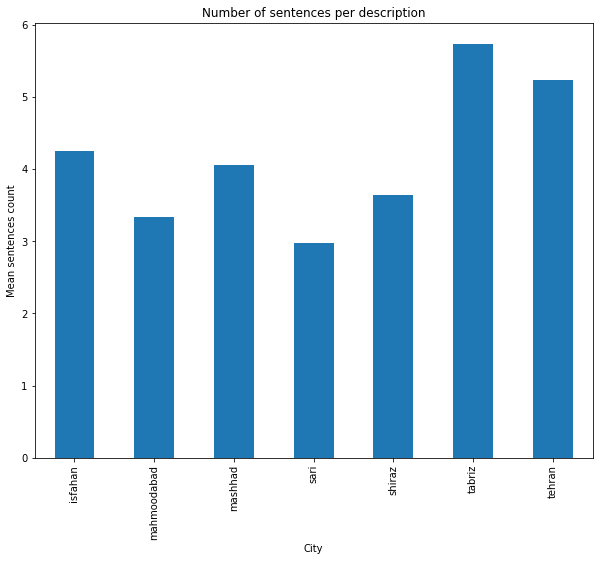

In [486]:
_ = n_sentences_per_city.plot(kind='bar', 
                              title='Number of sentences per description', 
                              ylabel='Mean sentences count',
                              xlabel='City', 
                              figsize=(10, 8))

### Number of words per sentence

<div style="direction:rtl"> 
    <font size="4", color="red">
         با توجه به حدسی که در قسمت قبل با توجه به نمودارها زده شد، در این قسمت میانگین تعداد کلمات بکار رفته در جملات را در هر یک از شهرها محاسبه و مقایسه می‌کنیم تا ببینیم آیا واقعا آگهی‌های املاکی که در شهر تهران گذاشته می‌شوند، دارای جملات کوتاه‌تری هستند؟
    </font> 
</div>

In [483]:
n_words_per_sentence_per_city = posts.groupby(['city'])['n_words', 'n_sentences'].mean()

<ipython-input-483-fa19d58b212d>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  n_words_per_sentence_per_city = posts.groupby(['city'])['n_words', 'n_sentences'].mean()


In [484]:
n_words_per_sentence_per_city = n_words_per_sentence_per_city.n_words / n_words_per_sentence_per_city.n_sentences

<div style="direction:rtl"> 
    <font size="4", color="red">
         همانطور که در نمودار زیر پیداست، می‌توان نتیجه گرفت که حدسمان درست بوده است و افراد در شهر تهران بیشتر از جملات کوتاه استفاده می‌کنند و سعی در خلاصه نوشتن جملات دارند.
    </font> 
</div>

<div style="direction:rtl"> 
    <font size="4", color="red">
        از طرف دیگر آگهی‌های املاک شهر محمودآباد دارای جملات با طول کلمات بیشتری هستند.
    </font> 
</div>

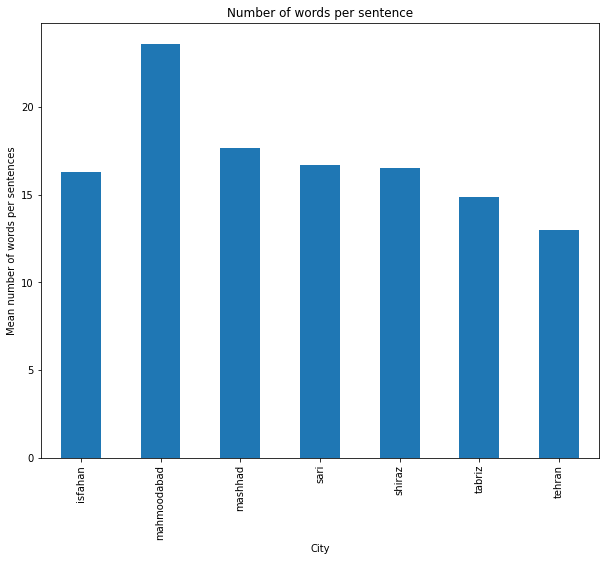

In [487]:
_ = n_words_per_sentence_per_city.plot(kind='bar', 
                              title='Number of words per sentence', 
                              ylabel='Mean number of words per sentences',
                              xlabel='City', 
                              figsize=(10, 8))

### Mean number of posts with instagram url

<div style="direction:rtl"> 
    <font size="4", color="red">
         در این قسمت به این می‌پردازیم که چه تعداد از پست‌های استخراج شده دارای username اینستاگرام و یا url ای از پست، استوری یا ... از اینستاگرام هستند که اگر این تعداد قابل توجه است، به منظور تمیز شدن و یکسان کردن آنها از یک توکن مثل INSTA به جای هر کدام استفاده کنیم.
    </font> 
</div>

<div style="direction:rtl"> 
    <font size="4", color="red">
        ابتدا به دنبال آگهی هایی که دارای username ای در خود هستند می‌گردیم که این عمل به کمک regex ای که برای آن نوشتم قابل بررسی است. همانطور که مشاهده می‌شود، این مورد فقط در یکی از آگهی‌ها آمده است که می‌توان نتیجه گرفت که نیازی به جایگزینی آنها با توکن دیگری نیست.
    </font> 
</div>

In [488]:
has_instagram_user = posts.Description.apply(
    lambda text: bool(re.search(r"@(?!.*\.\.)(?!.*\.$)[^\W][a-zA-Z0-9._]{1,30}", text))
)

In [489]:
sum(has_instagram_user)

1

In [490]:
posts[has_instagram_user].Description.iloc[0]

'<p class= «kt-description-row__text kt-description-row__text--primary» >شمشک❄️\n\nفروش\n\n❌قیمت اکازیون❌\n\nبهترین لوکیشن\n\nساختمان ۹ طبقه\n\n۱۱۰ متر ۲خواب\n\n۱ خواب مستر\n\nواحدها بصورت نیم طبقه میباشد\n\nتراس قابل چیدمان\n\nویو بینظیر ابدی\n\nسند تک برگ بدون ریشه\n\nسرایدار مقیم\n\nلابی انباری آسانسور\n\n❌پارکینگ ندارد❌\n\nآرین\n **************\n\u200f @Arian_home۱\n\n\u200f\n#لواسان#لواسانات#اوشان#فشم#میگون#میگون_نو#\n#شمشک#دربندسر#پیست_اسکی #پیست_اسکی_شمشک #پیست_اسکی_دربندسر☃️❄☃️❄ #نوساز #لاکچری#لابی_لابی_من۲۴ساعته #تراس_قابل_چیدمان#لابی_مجلل#ویو_ابدی#ویو_پیست_اسکی#_آرین_هوم#آرین_هوم۱</p>'

<div style="direction:rtl"> 
    <font size="4">
        ابتدا به دنبال آگهی هایی که دارای url ای از اینستاگرام در خود هستند می‌گردیم که این عمل به کمک regex ای که برای آن نوشتم قابل بررسی است. سعی کردم در این regex تمامی حالات یک url اینستاگرام از جمله url اکانت، پست و استوری را پوشش درهم. همانطور که مشاهده می‌شود، این مورد فقط در هیچ کدام از آگهی‌ها نیامده است که می‌توان نتیجه گرفت که نیازی به جایگزینی آنها با توکن دیگری نیست. همچنین این مورد می‌تواند این احتمال را قوی کند که شاید سایت دیوار اجازه‌ی قرار دادن url ای از اینستاگرام را در خود نمی‌دهد.
    </font> 
</div>

In [491]:
has_instagram_url = posts.Description.apply(
    lambda text: bool(re.search(r"(http:\/\/www\.|https:\/\/www\.|http:\/\/|https:\/\/|www.)?instagram.com(\/\w+)*(:\w+)*(\/?\?(\w+=\w+)(&\w+=\w+)*)?", text))
)

In [492]:
sum(has_instagram_url)

0

## Preprocessing Pipeline

<div style="direction:rtl"> 
    <font size="4", color="red">
        در این قسمت تمامی transformer هایی که پیش از این نوشتیم را روی داده‌ی نورمالایز شده به صورت یک پایپ‌لاین sklearn اعمال می‌کنیم تا در نهایت به داده‌ی تمیز برسیم.
    </font> 
</div>

In [493]:
preprocess_pipeline = Pipeline([
    ('tag', RemoveTagTransformer()),
    ('emoji', RemoveEmojiesTransformer(column_name='Description')),
    ('desc', DescriptionTransformer(column_name='Description')),
    ('sw', RemoveStopwordsTransformer(column_name='Description'))
])

In [494]:
posts = preprocess_pipeline.fit_transform(posts)

### Address in conversation

<div style="direction:rtl"> 
    <font size="4", color="red">
        در ادامه به کمک پکیج parsi.io بررسی می‌کنیم که نسبتی از آگهی‌های املاک هر شهر شامل آدرس ملک در توضیحات می‌باشند و همچنین نسبت تعداد آدرس به ازای یک آگهی را به ازای هر شهر محاسبه و مقایسه می‌کنیم.
    </font> 
</div>

In [500]:
adr_extractor = AddressExtraction()

In [501]:
# calculate number of words per description
posts['addresses_in_conv'] = posts.Description.apply(
    lambda desc: adr_extractor.run(desc)['address']
)

In [502]:
posts['n_addresses_in_conv'] = posts.addresses_in_conv.apply(len)

In [503]:
n_addresses_in_conv_per_city = posts.groupby(['city'])['n_addresses_in_conv'].mean()

<div style="direction:rtl"> 
    <font size="4", color="red">
        ابتدا نمودار تعداد آدرس به ازای یک آگهی را برای هر شهر محاسبه می‌کنیم. همانطور که در نمودار پیداست، در تبریز و سپس محمودآباد بیشترین تکرار آدرس و در مشهد کمترین تعداد تکرار آدرس در توضیحات آگهی وجود دارد.
    </font> 
</div>

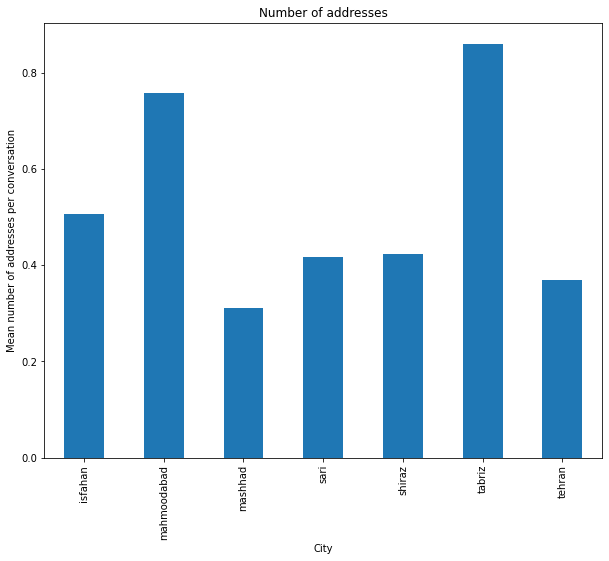

In [505]:
_ = n_addresses_in_conv_per_city.plot(kind='bar', 
                              title='Number of addresses', 
                              ylabel='Mean number of addresses per conversation',
                              xlabel='City', 
                              figsize=(10, 8))

In [506]:
posts['has_addresses_in_conv'] = posts.n_addresses_in_conv.apply(
    lambda n: n>0
)

In [507]:
mean_posts_with_address_per_city = posts.groupby(['city'])['has_addresses_in_conv'].mean()

<div style="direction:rtl"> 
    <font size="4", color="red">
        همانطور که در این نمودار پیداست، نسبت آگهی‌هایی که در توضیحات خود دارای آدرس هستند در محمودآباد و سپس تبریز بیشترین و در مشهد کمترین مقدار را دارد. تفاوت این نمودار با نمودار پیشین این است که نمودار پیشین تعداد آدرس آمده در یک آگهی را به صورت میانگین محاسبه می‌کند در صورتی که در این نمودار تنها آمدن و یا نیامدن آدرس در توضیحات آگهی مورد نظر است و چند بار آمدن آن مورد بررسی نیست.
    </font> 
</div>

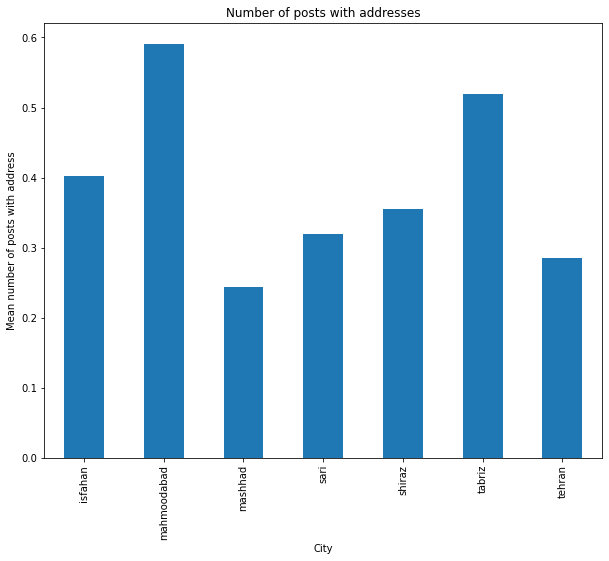

In [509]:
_ = mean_posts_with_address_per_city.plot(kind='bar', 
                                          title='Number of posts with addresses', 
                                          ylabel='Mean number of posts with address',
                                          xlabel='City', 
                                          figsize=(10, 8))

## Most common words

In [510]:
tehran_posts = posts[posts.city == 'tehran']
tabriz_posts = posts[posts.city == 'tabriz']
isfahan_posts = posts[posts.city == 'isfahan']
mashhad_posts = posts[posts.city == 'mashhad']
sari_posts = posts[posts.city == 'sari']
shiraz_posts = posts[posts.city == 'shiraz']
mahmoodabad_posts = posts[posts.city == 'mahmoodabad']

In [511]:
all_posts_tokens = [word_tokenize(desc) for desc in tqdm.tqdm(posts.Description)]
tehran_posts_tokens = [word_tokenize(desc) for desc in tqdm.tqdm(tehran_posts.Description)]
tabriz_posts_tokens = [word_tokenize(desc) for desc in tqdm.tqdm(tabriz_posts.Description)]
isfahan_posts_tokens = [word_tokenize(desc) for desc in tqdm.tqdm(isfahan_posts.Description)]
mashhad_posts_tokens = [word_tokenize(desc) for desc in tqdm.tqdm(mashhad_posts.Description)]
sari_posts_tokens = [word_tokenize(desc) for desc in tqdm.tqdm(sari_posts.Description)]
shiraz_posts_tokens = [word_tokenize(desc) for desc in tqdm.tqdm(shiraz_posts.Description)]
mahmoodabad_posts_tokens = [word_tokenize(desc) for desc in tqdm.tqdm(mahmoodabad_posts.Description)]

100%|██████████| 455/455 [00:00<00:00, 27478.88it/s]


In [512]:
all_tokens = list(itertools.chain(*all_posts_tokens))
tehran_tokens = list(itertools.chain(*tehran_posts_tokens))
tabriz_tokens = list(itertools.chain(*tabriz_posts_tokens))
isfahan_tokens = list(itertools.chain(*isfahan_posts_tokens))
mashhad_tokens = list(itertools.chain(*mashhad_posts_tokens))
sari_tokens = list(itertools.chain(*sari_posts_tokens))
shiraz_tokens = list(itertools.chain(*shiraz_posts_tokens))
mahmoodabad_tokens = list(itertools.chain(*mahmoodabad_posts_tokens))

In [513]:
dataframe = {}

for opt in ['all', 'tehran', 'tabriz', 'isfahan', 'mashhad', 'sari', 'shiraz', 'mahmoodabad']:
    dataframe[opt] = FreqDist(eval(F"{opt}_tokens")).most_common(50)

freq_analysis = pd.DataFrame(dataframe)

In [514]:
posts.city.value_counts()

mashhad        456
mahmoodabad    455
isfahan        453
sari           453
shiraz         451
tabriz         450
tehran         449
Name: city, dtype: int64

<div style="direction:rtl"> 
    <font size="4", color="red">
        با دقت در جدول زیر می‌توان متوجه اطلاعات جالبی شد. به طور مثال اینکه به ترتیب در تهران و شیراز کلمات سالن و نقشه به نسبت دیگر شهر ها پرتکرارتر هستند. می‌توان از این مورد نتیجه گرفت که احتمالا در شهر های تهران و شیراز خوش نقشه بودن سالن واحد برای خریدار اهمیت بیشتری دارد که می‌توان این مورد را به گران بودن واحدها در تخران و شیراز نسبت داد و در ادامه‌ی آن کوچک‌تر بودن واحدها به نسبت دیگر شهرها اشاره کرد. 
    </font> 
</div>

<div style="direction:rtl"> 
    <font size="4", color="red">
        یا اینکه در شهر ساری کلمه‌ی بنا به نسبت سایر شهر ها بسیار پرتکرار بوده است که می‌تواند نشان از پر اهمیت بودن بنا در خریداران شهر ساری داشته باشد. 
    </font> 
</div>

<div style="direction:rtl"> 
    <font size="4", color="red">
        همچنین با دقت در کلمات کلیدی آگهی‌های شهر اصفهان، می‌توان به تکرار بسیار کلمه‌ی نور توجه کرد که به نسبت شهرهای دیگر در اصفهان بسیار پرتکرار بوده است که می‌تواند نشان از دغدغه‌ی نور در خریداران واحد در اصفهان داشته باشد. 
    </font> 
</div>

<div style="direction:rtl"> 
    <font size="4", color="red">
        همچنین کلمات چوب و سنگ در شهر مشهد می‌توانند بسیار قابل توجه باشد. به صورتی که این دو کلمه در شهر مشهد جز پرتکرارترین کلمات هستند در صورتی که در شهرهای دیگر اصلا پرتکرار نیستند. این نکته می‌تواند نشان از علاقه‌ی خریداران واحد در مشهد به نماهای سنگ و چوب داشته باشد. 
    </font> 
</div>

<div style="direction:rtl"> 
    <font size="4", color="red">
        اگر به کلمات کلیدی و پرتکرار آگهی‌های شهر محمودآباد دقت کنیم، متوجه دو کلمه‌ی ساحل و دریا می‌شویم که با توجه به موقعیت جغرافیایی این شهر و نزدیک بودن آن به دریای خضر، بسیار نکات کلیدی‌ای در ارزش یک واحد در این شهر می‌باشند. 
    </font> 
</div>

<div style="direction:rtl"> 
    <font size="4", color="red">
        برای بررسی بیشتر می‌توان به متن آگهی‌هایی که کلمات خاصی را در یک شهر دارند توجه بیشتری کرد و نکاتی از آنها استخراج کرد. به عنوان مثال تعداد تکرار کلمه‌ی فروش در محمودآباد از تعداد آگهی‌های آن بیشتر است که تفاوت جالبی نسبت به دیگر شهر هاست. با بررسی آگهی‌های شهر محمودآباد و تمرکز روی جملاتی که در آنها کلمه‌ی فروش تکرار شده است می‌توان دلیل آنرا متوجه شد که در ادامه به بررسی این مورد خاص پرداخته می‌شود. 
    </font> 
</div>

In [516]:
freq_analysis

,all,tehran,tabriz,isfahan,mashhad,sari,shiraz,mahmoodabad
0,"(واحد, 2529)","(متر, 276)","(املاک, 515)","(املاک, 356)","(واحد, 259)","(طبقه, 365)","(املاک, 364)","(طبقه, 657)"
1,"(طبقه, 2013)","(واحد, 275)","(واحد, 429)","(واحد, 330)","(عالی, 246)","(واحد, 340)","(واحد, 343)","(فروش, 582)"
2,"(املاک, 1799)","(منطقه, 222)","(ملک, 297)","(عالی, 261)","(خواب, 202)","(پارکینگ, 234)","(عالی, 222)","(واحد, 553)"
3,"(فروش, 1495)","(سالن, 213)","(دارا, 280)","(طبقه, 240)","(دیوار, 199)","(متری, 185)","(خواب, 182)","(آپارتمان, 487)"
4,"(خواب, 1384)","(خواب, 212)","(فروش, 277)","(نور, 238)","(کابینت, 192)","(خواب, 184)","(نقشه, 167)","(کد, 385)"
5,"(آپارتمان, 1381)","(عالی, 201)","(طبقه, 252)","(تماس, 223)","(طبقه, 190)","(فروش, 176)","(آپارتمان, 163)","(خواب, 340)"
6,"(عالی, 1300)","(طبقه, 196)","(آدرس, 233)","(پارکینگ, 185)","(املاک, 190)","(عالی, 174)","(تماس, 162)","(شهر, 336)"
7,"(پارکینگ, 1217)","(پارکینگ, 187)","(تماس, 210)","(خواب, 182)","(متری, 163)","(متر, 171)","(سالن, 161)","(تعداد, 311)"
8,"(متر, 1182)","(نقشه, 184)","(دیوار, 197)","(آپارتمان, 181)","(سرامیک, 159)","(نما, 160)","(سند, 160)","(NUM, 307)"
9,"(تماس, 1138)","(نور, 163)","(سند, 194)","(متر, 167)","(کف, 158)","(آپارتمان, 156)","(جنوبی, 148)","(متری, 290)"


### Mahmoodabad posts with فروش word

In [533]:
total_posts = get_concatenated_data()
mahmood_abad_posts = total_posts[total_posts.city == 'mahmoodabad']
mahmood_abad_posts.reset_index(drop=True, inplace=True)

In [536]:
# calculate number of words per description
mahmoodabad_sentences_with_sell = mahmood_abad_posts.Description.apply(
    lambda desc: sentence_tokenizer.tokenize(desc)
)

In [546]:
mahmoodabad_sentences_with_sell = np.concatenate(mahmoodabad_sentences_with_sell)

In [554]:
mahmoodabad_sentences_with_sell = list(filter(lambda sent: 'فروش' in sent, mahmoodabad_sentences_with_sell))

In [555]:
mahmoodabad_sentences_with_sell[0]

'<p class="kt-description-row__text kt-description-row__text--primary">کد ۶۹۱ *اپارتمان طبقه اول* ۴ طبقه دو واحدی ۸۵ متر بنا دوخواب کابینت ام دی اف کف سرامیک فروشنامه ای</p>'

<div style="direction:rtl"> 
    <font size="4", color="red">
         همانطور که در انتهای قسمت قبلی بیان شد، تصمیم گرفتم این مورد را به طور خاص بررسی کنم که دلیل تکرار بسیار زیاد کلمه‌ی فروش در آگهی‌های فروش آپارتمان در محمودآباد چیست. برای این منظور جملات آگهی‌هایی که در آنها کلمه‌ی فروش آمده است را مورد بررسی قرار دادم. برای این منظور یک سمپل ۲۰تایی از آنها را گرفتم و متن توضیحات آنها را خواندم. به صورت عمده کلمه‌ی فروش به دو صورت در آگهی‌های این شهر می‌آید. ۱. حالت اول این است که در توضیحات آگهی مجددا به فروشی بودن واحد اشاره می‌شود که این آگهی مختص فروش واحد ... است. ۲. حالت دوم هم به صورت مضاف‌الیه کلمه‌های کارشناس و مشاور به صورت کارشناس فروش و یا مشاور فروش می‌آید.
    </font> 
</div>

<div style="direction:rtl"> 
    <font size="4", color="red">
        با توجه به آنچه گفته شد به نظر می‌رسد دلیل این تکرار زیاد کلمه‌ی فروش به خاطر نوع جمله‌بندی‌ای است که در این شهر مرسوم شده است و کلمه‌ی فروش بار معنایی جداگانه‌ای به توضیحات اضافه نمی‌کند.
    </font> 
</div>

In [558]:
for desc in random.sample(mahmoodabad_sentences_with_sell, 20):
    print(desc)
    print('\n' + '#'*100 + '\n')

<p class="kt-description-row__text kt-description-row__text--primary">کد۴۳۰ درود به دوستان گرامی  ۴طبقه ۲ واحدی  فروش طبقه ۱ سند تکبرک  مدارک تکمیل آماده انتقال  شهری دسترسی به مراکز خرید و رفاهی  ۵دقیقه پیاده تا ساحل  ویلا آپارتمان زمین متناسب با بودجه وسلیقه و شرایط شما  خانم عزیزی مشاور امور ملکی در شمال در پناه خدا</p>

####################################################################################################

⭕  خرید بدون واسطه ازسازنده      برای کسب اطلاعات بیشتر و موارد مشابه تماس بگیرید             __________________              کد: A664  ////////    کارشناس فروش: خانم پهلوی   ***********  ⭕ ***********  ⭕ ***********</p>

####################################################################################################

<p class="kt-description-row__text kt-description-row__text--primary">فروش آپارتمان نوساز کد:258 واحد 87 متر پارکینگ  انباری بالکن آسانسور طبقه اول  2 خوابه 1 خواب مستر فاصله با ساحل برند منطقه 100 متر کابینت و کمد هایگلاس درجه یک شیر و اتصالات نصب